### Set up environment

In [1]:
!pip install oscn==0.0.0.25

import oscn

  Found existing installation: oscn 0.0.0.31
    Uninstalling oscn-0.0.0.31:
      Successfully uninstalled oscn-0.0.0.31


In [2]:
oscn.request.Case().docket

### Set up the OSCN information needed

In [2]:

years = ['2017','2018']
counties = ['tulsa', 'mayes', 'delaware']
types =['CM','CF']

### Request the cases from OSCN and save as files
This takes a couple hours

In [3]:
import pickle


# for county in counties:
#   for year in years:
#     for type in types:      
#       cases=oscn.request.CaseList(type=type, year=year,county=county)
#       all_cases = [c for c in cases]
#       file_name = f'data/{type}.{county}.{year}.oscn'
#       f = open(file_name, 'wb')
#       z(all_cases, f)
#       f.close()
#       print(f'{file_name}: {len(all_cases)}')


### Retrieve the saved files

In [4]:
import pickle
import zlib

case_count =0 
saved_cases =[]


# restore_cases = lambda compressed_case: pickle.loads(zlib.decompress(compressed_case) )

for county in counties:
  for year in years:
    for type in types:      
      file_name = f'data/{county}.{year}.{type}.cases'
      pickled_cases = zlib.decompress(open(file_name, 'rb').read(), zlib.MAX_WBITS)  
      new_cases =  [case for case in pickle.loads(pickled_cases)]
    
      new_case_count = len(new_cases)
      case_count += new_case_count
      print(f'{file_name} added {new_case_count}')
      saved_cases += new_cases
        
print(f'counted case: {case_count} length saved {len(saved_cases)}')

data/tulsa.2017.CM.cases added 6050
data/tulsa.2017.CF.cases added 6587
data/tulsa.2018.CM.cases added 5024
data/tulsa.2018.CF.cases added 4834
data/mayes.2017.CM.cases added 629
data/mayes.2017.CF.cases added 425
data/mayes.2018.CM.cases added 451
data/mayes.2018.CF.cases added 332
data/delaware.2017.CM.cases added 930
data/delaware.2017.CF.cases added 440
data/delaware.2018.CM.cases added 861
data/delaware.2018.CF.cases added 433
counted case: 26996 length saved 26996


## Create a pandas dataframe

In [6]:
import re
import numpy as np
import pandas as pd

columns = ['Filed','County','Type', 'CaseNumber', 'Counts','Source']
case_data = lambda c: [c.filed, c.county, c.type, c.case_number, c.counts, c.source]
%time all_cases = pd.DataFrame([case_data(c) for c in saved_cases], columns = columns)

['Filed', 'County', 'Type', 'CaseNumber', 'Counts', 'Source']

In [ ]:
all_cases.groupby(['County']).count()

In [21]:
all_cases.head(5)

,Filed,County,Type,CaseNumber,Counts,Source,Charge
0,2017-01-03,mayes,CM,CM-2017-1,[{'description': 'POSSESSION OF CONTROLLED DAN...,https://www.oscn.net/dockets/GetCaseInformatio...,
1,2017-01-03,mayes,CM,CM-2017-2,[{'description': 'PUBLIC INTOXICATION'}],https://www.oscn.net/dockets/GetCaseInformatio...,
2,2017-01-04,mayes,CM,CM-2017-3,"[{'description': 'PETIT LARCENY'}, {'descripti...",https://www.oscn.net/dockets/GetCaseInformatio...,
3,2017-01-04,mayes,CM,CM-2017-4,[{'description': 'DOMESTIC ABUSE - ASSAULT AND...,https://www.oscn.net/dockets/GetCaseInformatio...,
4,2017-01-04,mayes,CM,CM-2017-5,[{'description': 'POSSESSION OF CONTROLLED DAN...,https://www.oscn.net/dockets/GetCaseInformatio...,


In [22]:
# charge_list = lambda charges:[charge['description'] for charge in charges ] if charges else []

# all_cases['Charge'] = [charge_list(counts) for counts in all_cases['Counts'] ] 

# all_cases.drop(columns=['Charge'])

## Expand Counts

In [40]:
# convert the date from a string to a python DateTime type
all_cases['FiledDate'] = pd.to_datetime(all_cases['Filed'])

# create a map to all the existing non Count data

safe_len = lambda counts: len(counts) if counts else 0
lens = all_cases['Counts'].apply(safe_len)
vals = range(all_cases.shape[0])
ilocations = np.repeat(vals, lens)

# get the index of all non Count columns
cols = [i for i,c in enumerate(all_cases.columns) if c != 'Counts']
# create a new expanded data frame and copy the old data
count_frame = all_cases.iloc[ilocations, cols].copy()

# Create a new column with the exanded data

description = lambda count: count['description'] if count else ""
safe_counts = lambda counts: counts if counts else {}
count_frame['Charge'] = [description(item) for items in all_cases['Counts'] for item in items]
count_frame.reset_index( inplace=True)

### Count of counts

In [43]:
count_frame.head()


,Filed,County,Type,CaseNumber,Source,Charge,FiledDate
0,2017-01-03,mayes,CM,CM-2017-1,https://www.oscn.net/dockets/GetCaseInformatio...,POSSESSION OF CONTROLLED DANGEROUS SUBSTANCE,2017-01-03
0,2017-01-03,mayes,CM,CM-2017-1,https://www.oscn.net/dockets/GetCaseInformatio...,UNLAWFUL POSSESSION OF DRUG PARAPHERNALIA,2017-01-03
1,2017-01-03,mayes,CM,CM-2017-2,https://www.oscn.net/dockets/GetCaseInformatio...,PUBLIC INTOXICATION,2017-01-03
2,2017-01-04,mayes,CM,CM-2017-3,https://www.oscn.net/dockets/GetCaseInformatio...,PETIT LARCENY,2017-01-04
2,2017-01-04,mayes,CM,CM-2017-3,https://www.oscn.net/dockets/GetCaseInformatio...,OBSTRUCTING OFFICER,2017-01-04


    ## Filter for bugus check counts

In [44]:
count_frame.describe()

,Filed,County,Type,CaseNumber,Source,Charge,FiledDate
count,6937,6938,6938,6938,6938,6938,6937
unique,418,2,2,2617,4191,918,418
top,2017-02-14 00:00:00,delaware,CM,CM-2017-53,https://www.oscn.net/dockets/GetCaseInformatio...,"UNLAWFUL POSSESSION OF DRUG PARAPHERNALIA, A M...",2017-02-14 00:00:00
freq,69,3841,3815,52,51,257,69
first,2017-01-03 00:00:00,NaN,NaN,NaN,NaN,NaN,2017-01-03 00:00:00
last,2018-09-10 00:00:00,NaN,NaN,NaN,NaN,NaN,2018-09-10 00:00:00


In [50]:
import re

bogus_count = re.compile(r'(utter.*forged|bogus)', re.I | re.M)

is_check_case= lambda row: True if bogus_count.search(row['Charge']) else False
    

count_frame['Bogus_Check'] = count_frame.apply(is_check_case, axis=1)


In [75]:
count_frame.reset_index( inplace=True)
count_frame.head()


,index,Filed,County,Type,CaseNumber,Source,Charge,FiledDate,Bogus_Check
0,0,2017-01-03,mayes,CM,CM-2017-1,https://www.oscn.net/dockets/GetCaseInformatio...,POSSESSION OF CONTROLLED DANGEROUS SUBSTANCE,2017-01-03,False
1,0,2017-01-03,mayes,CM,CM-2017-1,https://www.oscn.net/dockets/GetCaseInformatio...,UNLAWFUL POSSESSION OF DRUG PARAPHERNALIA,2017-01-03,False
2,1,2017-01-03,mayes,CM,CM-2017-2,https://www.oscn.net/dockets/GetCaseInformatio...,PUBLIC INTOXICATION,2017-01-03,False
3,2,2017-01-04,mayes,CM,CM-2017-3,https://www.oscn.net/dockets/GetCaseInformatio...,PETIT LARCENY,2017-01-04,False
4,2,2017-01-04,mayes,CM,CM-2017-3,https://www.oscn.net/dockets/GetCaseInformatio...,OBSTRUCTING OFFICER,2017-01-04,False


In [76]:
count_frame.groupby(['County'])['Bogus_Check'].value_counts()


County    Bogus_Check
delaware  False          3670
          True            171
mayes     False          3061
          True             36
Name: Bogus_Check, dtype: int64

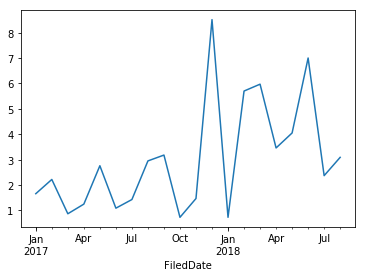

In [78]:
import matplotlib.pyplot as plt

month = count_frame.FiledDate.dt.to_period("M")

counts_with_bogus = count_frame.query("Bogus_Check == True")
groups = [month]
by_month=round(counts_with_bogus.groupby(groups).size()/count_frame.groupby(groups).size()*100,2)
by_month.plot.line()

0      2017-01
0      2017-01
1      2017-01
2      2017-01
2      2017-01
2      2017-01
3      2017-01
4      2017-01
4      2017-01
5      2017-01
5      2017-01
6      2017-01
7      2017-01
8      2017-01
8      2017-01
8      2017-01
8      2017-01
9      2017-01
10     2017-01
11     2017-01
12     2017-01
13     2017-01
14     2017-01
14     2017-01
15     2017-01
15     2017-01
15     2017-01
16     2017-01
17     2017-01
17     2017-01
         ...  
4185   2018-09
4185   2018-09
4185   2018-09
4186   2018-09
4186   2018-09
4186   2018-09
4187   2018-08
4188   2018-08
4189   2018-08
4190   2018-08
4190   2018-08
4190   2018-08
4190   2018-08
4190   2018-08
4190   2018-08
4191   2018-09
4191   2018-09
4192   2018-09
4193   2018-09
4193   2018-09
4193   2018-09
4193   2018-09
4194   2018-09
4194   2018-09
4195   2018-09
4196   2018-09
4196   2018-09
4196   2018-09
4197   2018-09
4197   2018-09
Name: FiledDate, Length: 6938, dtype: object